In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random 
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i, s in stoi.items()}
block_size = 5  
def build_dataset(words):
    X , Y = [],[]                       # X = Input          Y = Labels
                     # Number of characters used to predict

    for w in words:                 #Iterate over words
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]               #Index du characters
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr , Ytr = build_dataset(words[:n1])
Xval , Yval = build_dataset(words[n1:n2])
Xtest , Ytest = build_dataset(words[n2:])

32033
torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [3]:
g = torch.Generator().manual_seed(2147483647)
nneurons = 400
dimention_embd = 20
C = torch.randn((27, dimention_embd), generator=g)
W1 = torch.randn((block_size*dimention_embd, nneurons), generator=g)
b1 = torch.randn(nneurons, generator=g)
W2 = torch.rand((nneurons, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [4]:
sum(p.nelement() for p in parameters)

51767

In [5]:
#ESTIMATE LEARNING RATE
iter = 200000
batch_size = 32

for i in range(iter):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0],( batch_size,))                       #Batch of total size
    
    #Forward pass
    embd = C[Xtr[ix]]
    h = torch.tanh(embd.view(embd.shape[0], embd.shape[1] * embd.shape[2]) @ W1 + b1)                   # embd.shape[0]
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])                        #Faster, single kernel, backward pass more efficient, more well behaved
    
    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr= lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #tracker
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print("loss is ", loss.item())

loss is  1.8518248796463013


In [6]:
#Train
embd = C[Xtr]
h = torch.tanh(embd.view(embd.shape[0], embd.shape[1] * embd.shape[2]) @ W1 + b1)                   # embd.shape[0]
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9339, grad_fn=<NllLossBackward0>)

In [7]:
#Validation
embd = C[Xval]
h = torch.tanh(embd.view(embd.shape[0], embd.shape[1] * embd.shape[2]) @ W1 + b1)                   # embd.shape[0]
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1108, grad_fn=<NllLossBackward0>)

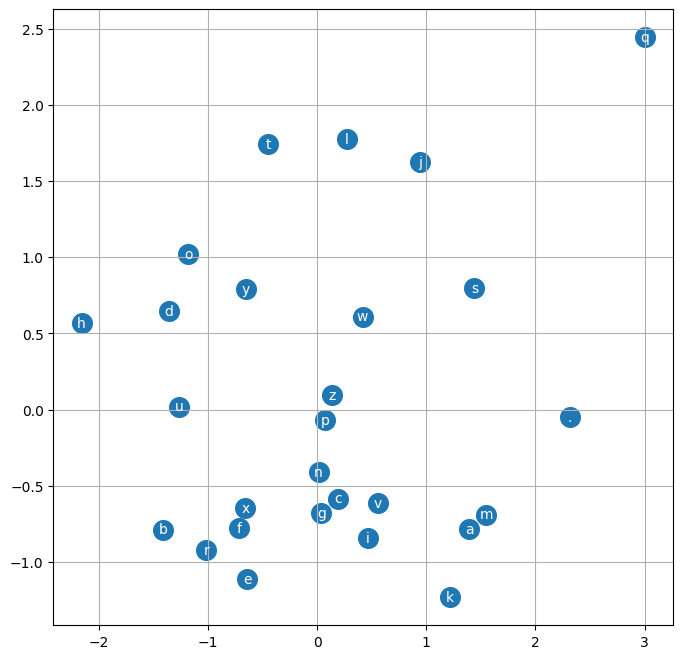

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range (C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color ="white")
plt.grid('minor')

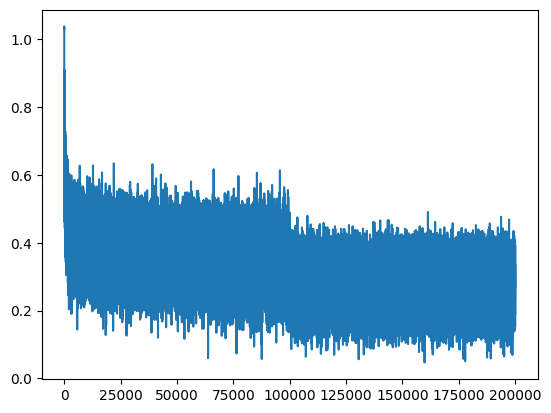

In [9]:
plt.plot(stepi, lossi)